In [1]:
# Scikit-image library for image processing tools in python
!pip3 install scikit-image
# Scikit-learn library for ML in python
!pip3 install scikit-learn
# install the library h5py (needed to load and read the ground truth relevance file of assignment 02)
!pip3 install h5py
# install the library tqdm (for progress visualization)
!pip3 install tqdm
# Matplotlib/Pylab for plots and visualization in python
!pip3 install matplotlib

### Things to try:
- use of different keypoint descriptors (e.g. SIFT, SURF, and so on) 
- study the impact of different clustering techniques to learn the visual dictionary (e.g. fuzzy k-means, soft k-means, hierarchical clustering) of different sizes of the vocabulary (values of k)
- use of different distance metrics to compare the final descriptors 
- the implementation of an inverted index using the learned visual vocabulary
- use of Machine Learning for learning to rank


## Load the query and map images

In [2]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm

# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])


## Load the similarity matrix

In [3]:
# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

## Visualize some images

(-0.5, 340.5, 255.5, -0.5)

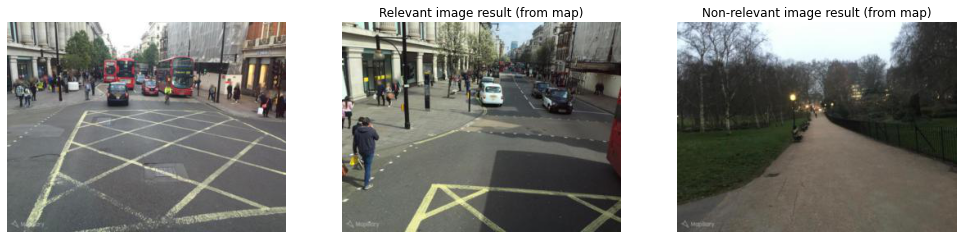

In [4]:
# generate random index for the query image
# You can try with it (but in the case a query image does not have relevant results in the map, the code will give an error)
query_idx = np.random.randint(0, 499) 

# For visualization purposes, we select a query image for which there are relevant and non-relevant results in the collection (map)
# query_idx = 120

# select the relevant and non-relevant map images for the randomly selected query image
rel = np.where(sim[query_idx, :] == 1)
nonrel = np.where(sim[query_idx, :] == 0)


# randomly select a relevant and non-relevant image
rel_idx = rel[0][np.random.randint(0, len(rel[0]) - 1)]
nonrel_idx = nonrel[0][np.random.randint(0, len(nonrel[0]) - 1)]

plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread('data02/' + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[rel_idx]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Non-relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[nonrel_idx]))
plt.axis("off")


## Bag of words

### Compute the descriptors

In [18]:
import os
import skimage
#from skimage.feature import ORB
from skimage.feature import SIFT
from skimage.color import rgb2gray
import cv2 as cv

# Initialize the descriptor
descriptor_extractor = SIFT()
#descriptor_extractor = ORB(n_keypoints=50)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)
    
# We have extracted 50 descriptors per image, for 1000 images. The ORB descriptors have length 256
print(descriptors.shape)

ImportError: cannot import name 'SIFT' from 'skimage.feature' (c:\Users\Frederico\anaconda3\lib\site-packages\skimage\feature\__init__.py)

### Save/Load the descriptors

In [6]:
import pickle
# save descriptors (uncomment if you want to save the computed descriptors)
f = open('data02/ORB-descriptors-map.bin', 'wb')
data = pickle.dump(descriptors, f)
f.close()

# load pre-computed descriptors
# f = open('data02/ORB-descriptors-map.bin', 'rb')
# descriptors = pickle.load(f)
# f.close()


### Create the clusters

In [7]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


Initialization complete
Iteration 0, inertia 4635999.0
Iteration 1, inertia 2760148.397122544
Iteration 2, inertia 2735759.2168654907
Iteration 3, inertia 2728212.4346136507
Iteration 4, inertia 2724213.995385612
Iteration 5, inertia 2721258.856697691
Iteration 6, inertia 2719039.467739728
Iteration 7, inertia 2717246.5802700957
Iteration 8, inertia 2715736.6746209217
Iteration 9, inertia 2714477.891569666
Iteration 10, inertia 2713433.80917981
Iteration 11, inertia 2712551.7007504683
Iteration 12, inertia 2711835.5274430364
Iteration 13, inertia 2711253.908562756
Iteration 14, inertia 2710798.3779133894
Iteration 15, inertia 2710416.037970399
Iteration 16, inertia 2710110.113500705
Iteration 17, inertia 2709825.8146809093
Iteration 18, inertia 2709597.300452331
Iteration 19, inertia 2709392.624336891
Iteration 20, inertia 2709200.0902995355
Iteration 21, inertia 2709043.1121591907
Iteration 22, inertia 2708911.04942335
Iteration 23, inertia 2708792.636637635
Iteration 24, inertia 2708

### save/load the centroids

In [8]:
# save centroids (uncomment if you want to save the computed centroids)
f = open('data02/ORB-centroids-map.bin', 'wb')
data = pickle.dump(centroids, f)
f.close()

# load pre-computed centroids
# f = open('data02/ORB-centroids-map.bin', 'rb')
# centroids = pickle.load(f)
# f.close()

### Compute the vector

In [9]:
from tqdm import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import euclidean_distances
descriptor_extractor = ORB(n_keypoints=50)


# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER        
        closest_dist = 9999
        index = 0
        for j in range(n_centroids):
            dist = np.linalg.norm(img_descriptors[i]-centroids[j])
            if(dist < closest_dist):
                closest_dist = dist
                index = j
        bow_vector[index] += 1
        ## END ANSWER
    return bow_vector


# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join('data02/', q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


Size of the bow vector:  (32,)
Bow vector:  [0. 3. 2. 2. 1. 0. 3. 0. 2. 6. 2. 1. 3. 2. 2. 0. 1. 0. 2. 0. 1. 0. 5. 0.
 3. 2. 2. 0. 1. 1. 0. 3.]


## Convert the images to BoW representation

In [10]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

100%|██████████| 1000/1000 [02:21<00:00,  7.07it/s]


## Normalization of data

In [11]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)


## Retrieve the images

In [12]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # use this to 
    
    ## BEGIN ANSWER
    for i in range(n_map_bow_vectors):
        dist = np.linalg.norm(map_bow_vectors[i]-query_bow)
        bow_distances[i] = dist
    
    most_similar = np.argsort(bow_distances, axis=- 1, kind=None, order=None)
    
    
    ## END ANSWER
    
    return most_similar



# Retrieve the most similar images to query image 221 (index 221-1=220)
query_idx = 220
img = plt.imread("data02/" + q_imgs[query_idx])
img = rgb2gray(img)
# compute bag of words
descriptor_extractor.detect_and_extract(img)  
query_img_descriptors = descriptor_extractor.descriptors 
bow = bag_of_words(centroids, query_img_descriptors)

# Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)
print('Indices of similar images retrieved: ', retrieved_images[:10])
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[query_idx, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

Indices of similar images retrieved:  [ 70 829  78 536 803 293 149 699 398 994]
Indices of relevant images (given in the GT relevance judgements):  [310 311 312 313 314 315 316 317 318 319 320 321 322 323 324]


## Evaluate performance

#### Precision at k

In [13]:
## BEGIN ANSWER
def precision(relevant, retrieved):
    count = 0
    if len(retrieved) > 0:
        for x in relevant:
            if x in retrieved:
                count += 1
        return count / len(retrieved)
    return 0
    
def precision_at_k(relevant, retrieved, k):
    kRetrieved = retrieved[0:k]
    return precision(relevant, kRetrieved)

prec5 = precision_at_k(relevant_images, retrieved_images, 5)
prec10 = precision_at_k(relevant_images, retrieved_images, 10)
## END ANSWER

print('P@5: ', prec5)
print('P@10: ', prec10)

P@5:  0.0
P@10:  0.0


#### Mean average precision

In [14]:
## BEGIN ANSWER
def average_precision(relevant, retrieved):
    avsum = 0
    for i in range(len(retrieved)):
        if retrieved[i] in relevant:
            pr = precision(relevant, retrieved[0:i+1])
            avsum += pr
    return avsum/len(relevant)

def mean_average_precision(all_relevant, all_retrieved):
    total = 0
    count = len(all_relevant)
    for i in range(len(all_relevant)):
        total += average_precision(all_relevant[i],all_retrieved[i])
    return total / count

relevant_images_MAP = []
retrieved_images_MAP = []
for i in range(len(sim)):
    relevant_images_MAP.append(np.where(sim[i, :] == 1)[0])
    
    img = plt.imread("data02/" + q_imgs[i])
    img = rgb2gray(img)
    # compute bag of words
    descriptor_extractor.detect_and_extract(img)  
    query_img_descriptors = descriptor_extractor.descriptors 
    bow = bag_of_words(centroids, query_img_descriptors)

    # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
    bow = scaler.transform(bow.reshape(-1, 1).transpose())
    bow = bow.transpose().reshape(-1)

    # Retrieve the indices of the top-10 similar images from the map
    retrieved_images_MAP.append(retrieve_images(bow_map_images, bow))

MAP = mean_average_precision(relevant_images_MAP, retrieved_images_MAP)
print('The mean average precision is: ', MAP)
## END ANSWER

The mean average precision is:  0.015273042358128123
